In [36]:
from statistics import mean
from statistics import stdev
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prettytable import PrettyTable
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import seaborn as sns
from scipy.stats import poisson
from datetime import datetime

## Bitcoin's and Bitcoin Cash's drift

The miner's block reward is halved every 210,000 blocks in order to control supply. The is a maximum supply of 21 million of coins. The first Bitcoin block was mined on January 09, 2009 02:54:25. 

Ideally, a block is mined every 10 minutes. If we multiply by 210,000, which is the number of blocks before every halving, we get 1458.33 days (almost 4 years).

References:

https://bitcoinblockhalf.com/

https://www.kucoin.com/learn/crypto/bitcoin-cash-halving-2024

https://www.blockchain.com/explorer/blocks/bch

In [37]:
print(210000 * 10 / 60 / 24, "days")
print(210000 * 10 / 60 / 24 / 365, "years")


1458.3333333333333 days
3.9954337899543377 years


In [38]:
timeAxis = pd.date_range(start='2009/01/09', end='2026/05/31')

BTC_halving_history = ['2009-01-09', '2012-11-28', '2016-07-09', '2020-05-11', '2024-04-20', '2026-05-31']
BCH_halving_history = ['2009-01-09', '2012-11-28', '2016-07-09', '2020-04-08', '2024-04-03', '2026-05-31']

ideal = np.zeros(len(timeAxis))
BTC_history = np.zeros(len(timeAxis))
BCH_history = np.zeros(len(timeAxis))

for i in range(5):
    if i == 4:
        ideal[i*1458 : (i+1)*1458] = 50 / 2**i
        BTC_history[timeAxis.get_loc(BTC_halving_history[i]):] = 50 / 2**i
        BCH_history[timeAxis.get_loc(BCH_halving_history[i]):] = 50 / 2**i
    else:
        ideal[i*1458 : (i+1)*1458] = 50 / 2**i
        BTC_history[timeAxis.get_loc(BTC_halving_history[i]):timeAxis.get_loc(BTC_halving_history[i+1])] = 50 / 2**i
        BCH_history[timeAxis.get_loc(BCH_halving_history[i]):timeAxis.get_loc(BCH_halving_history[i+1])] = 50 / 2**i

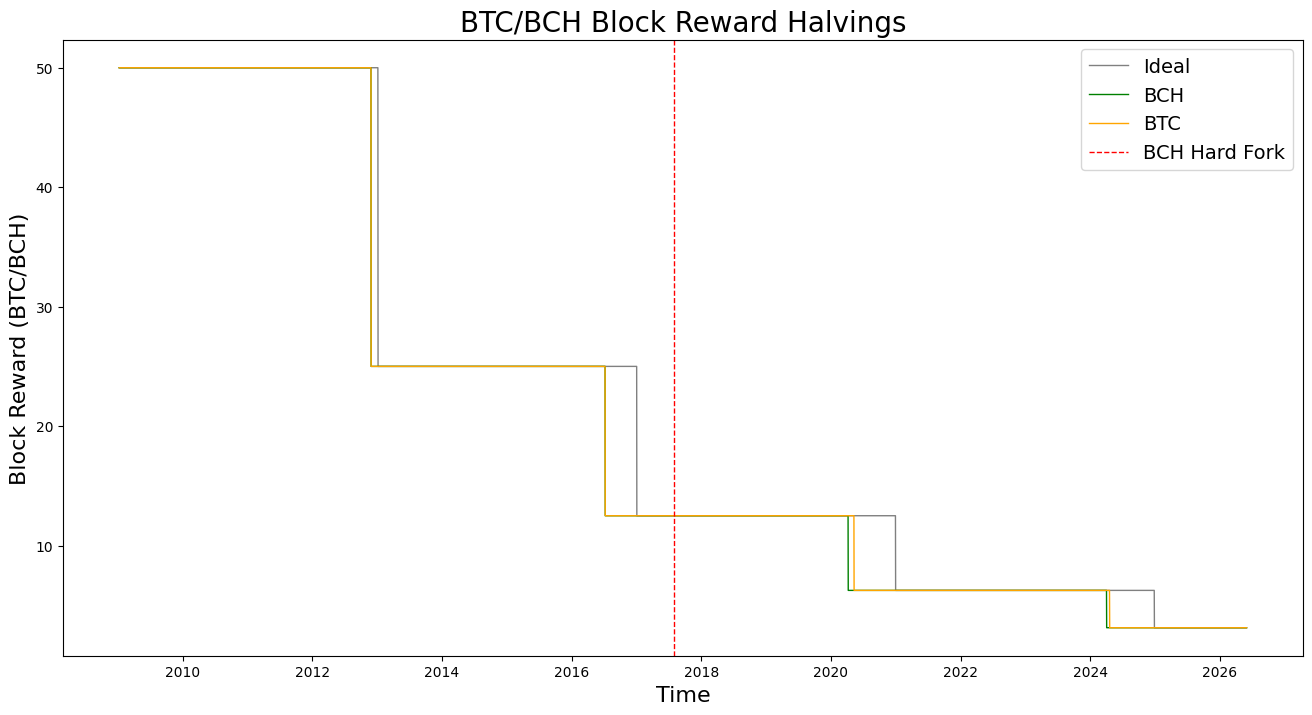

In [39]:
plt.plot(timeAxis, ideal, label='Ideal', color='gray', linewidth=1)
plt.plot(timeAxis, BCH_history, label='BCH', color='green', linewidth=1)
plt.plot(timeAxis, BTC_history, label='BTC', color='orange', linewidth=1)
plt.axvline(pd.Timestamp('2017-08-01'), color='r', linestyle='--', linewidth=1, label='BCH Hard Fork')
plt.title('BTC/BCH Block Reward Halvings', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Block Reward (BTC/BCH)', fontsize=16)
plt.legend(fontsize=14)
plt.gcf().set_size_inches(16, 8)
# Hard fork on 01 Aug 2017

In [40]:
supplyTable = PrettyTable(["", "Ideal", "BTC", "BCH"])
supplyTable.add_row(["Genesis Block (block 0 - miner reward 50 BTC)","","",""], divider=True)
supplyTable.add_row(["Date", timeAxis[0].date() , BTC_halving_history[0] , BCH_halving_history[0]], divider=True)

for i in range(2,6):
    supplyTable.add_row(["Halving " + str(i-1) + " (block " + str(210000 * (i-1)) + " - miner reward " + str(50 / (2**(i-1))) + " BTC)","","",""], divider=True)
    supplyTable.add_row(["Date", timeAxis[1458 * (i-1)].date() , BTC_halving_history[i-1] , BCH_halving_history[i-1]])
    supplyTable.add_row(["time since last halving (days)", "1458" , timeAxis.get_loc(BTC_halving_history[i-1]) - timeAxis.get_loc(BTC_halving_history[i-2]) , timeAxis.get_loc(BCH_halving_history[i-1]) - timeAxis.get_loc(BCH_halving_history[i-2])])
    supplyTable.add_row(["Deviation (drift) from the ideal (days)", "0", timeAxis.get_loc(BTC_halving_history[i-1]) - timeAxis.get_loc(BTC_halving_history[i-2]) - 1458 , timeAxis.get_loc(BCH_halving_history[i-1]) - timeAxis.get_loc(BCH_halving_history[i-2]) - 1458])
    supplyTable.add_row(["time since genesis (days)", 1458 * (i-1) , timeAxis.get_loc(BTC_halving_history[i-1]) , timeAxis.get_loc(BCH_halving_history[i-1])])
    supplyTable.add_row(["Deviation (drift) from the ideal (days)", "0" , timeAxis.get_loc(BTC_halving_history[i-1]) - 1458 * (i-1) , timeAxis.get_loc(BCH_halving_history[i-1]) - 1458 * (i-1)])
    supplyTable.add_row(["", "", "", ""], divider=True)


supplyTable.align[""] = "l"
supplyTable.align["Ideal"] = "l"
supplyTable.align["BTC"] = "l"
supplyTable.align["BCH"] = "l"
print(supplyTable)

+---------------------------------------------------+------------+------------+------------+
|                                                   | Ideal      | BTC        | BCH        |
+---------------------------------------------------+------------+------------+------------+
| Genesis Block (block 0 - miner reward 50 BTC)     |            |            |            |
+---------------------------------------------------+------------+------------+------------+
| Date                                              | 2009-01-09 | 2009-01-09 | 2009-01-09 |
+---------------------------------------------------+------------+------------+------------+
| Halving 1 (block 210000 - miner reward 25.0 BTC)  |            |            |            |
+---------------------------------------------------+------------+------------+------------+
| Date                                              | 2013-01-06 | 2012-11-28 | 2012-11-28 |
| time since last halving (days)                    | 1458       | 141

## Real Data (2017-01-01 to 2024-05-31)

In [41]:
df_BTC = pd.read_csv('../data/BTC_filtered_file.csv')
df_BCH = pd.read_csv('../data/BCH_filtered_file.csv')

In [42]:
df_BCH.head()

,id,time,median_time,bits,difficulty,chainwork
0,446033,2017-01-01 00:02:33,2016-12-31 23:19:58,402879999,3.176884e+11,00000000000000000000000000000000000000000035fb...
1,446034,2017-01-01 00:32:32,2016-12-31 23:21:17,402879999,3.176884e+11,00000000000000000000000000000000000000000035fc...
2,446035,2017-01-01 00:36:24,2016-12-31 23:28:29,402879999,3.176884e+11,00000000000000000000000000000000000000000035fc...
3,446036,2017-01-01 00:40:19,2016-12-31 23:37:07,402879999,3.176884e+11,00000000000000000000000000000000000000000035fc...
4,446037,2017-01-01 00:40:44,2016-12-31 23:44:04,402879999,3.176884e+11,00000000000000000000000000000000000000000035fd...


### Block times

In [43]:
df_BCH['block_time'] = pd.to_datetime(df_BCH['median_time']).diff().dt.total_seconds().fillna(0)
df_BTC['block_time'] = pd.to_datetime(df_BTC['median_time']).diff().dt.total_seconds().fillna(0)

In [44]:
print('BCH real data:')
print('mean:',df_BCH['block_time'].mean())
print('stdev:',df_BCH['block_time'].std())

print('BTC real data:')
print('mean:',df_BTC['block_time'].mean())
print('stdev:',df_BTC['block_time'].std())

BCH real data:
mean: 581.703629668857
stdev: 732.5180059460064
BTC real data:
mean: 585.0012351574826
stdev: 585.6168914206042


In [45]:
df_BCH_EDA = df_BCH[(df_BCH['time'] >= '2017-08-01') & (df_BCH['time'] <= '2017-11-13')]
df_BCH_CW144 = df_BCH[(df_BCH['time'] >= '2017-11-13') & (df_BCH['time'] <= '2020-11-15')]
df_BCH_ASERT = df_BCH[(df_BCH['time'] >= '2020-11-15')]

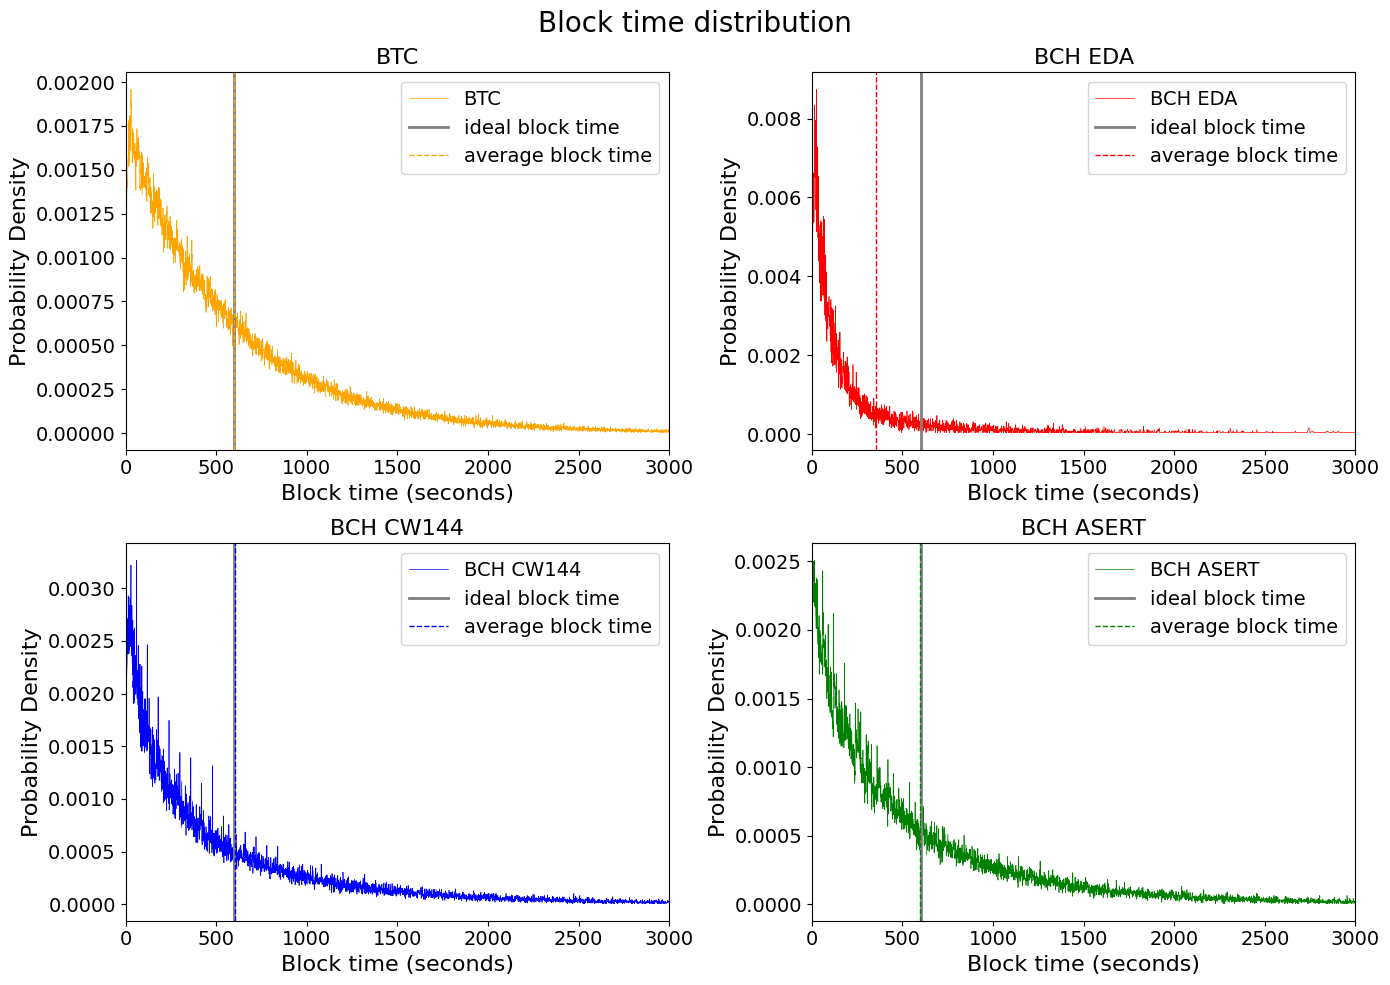

In [46]:
BTC_pdf_block_time = df_BTC['block_time'].value_counts(normalize=True).sort_index()
BCH_EDA_pdf_block_time = df_BCH_EDA['block_time'].value_counts(normalize=True).sort_index()
BCH_CW144_pdf_block_time = df_BCH_CW144['block_time'].value_counts(normalize=True).sort_index()
BCH_ASERT_pdf_block_time = df_BCH_ASERT['block_time'].value_counts(normalize=True).sort_index()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(BTC_pdf_block_time.index, BTC_pdf_block_time.values, color='orange', label='BTC', linewidth=0.5)
axs[0, 0].axvline(600, color='gray', linestyle='-', linewidth=2, label='ideal block time')
axs[0, 0].axvline(df_BCH_ASERT['block_time'].mean(), color='orange', linestyle='--', linewidth=1, label='average block time')
axs[0, 0].set_title('BTC', fontsize=16)
axs[0, 0].set_xlabel('Block time (seconds)', fontsize=16)
axs[0, 0].set_ylabel('Probability Density', fontsize=16)
axs[0, 0].set_xlim(0, 3000)
axs[0, 0].legend(fontsize=14)
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)

axs[0, 1].plot(BCH_EDA_pdf_block_time.index, BCH_EDA_pdf_block_time.values, color='red', label='BCH EDA', linewidth=0.5)
axs[0, 1].axvline(600, color='gray', linestyle='-', linewidth=2, label='ideal block time')
axs[0, 1].axvline(df_BCH_EDA['block_time'].mean(), color='red', linestyle='--', linewidth=1, label='average block time')
axs[0, 1].set_title('BCH EDA', fontsize=16)
axs[0, 1].set_xlabel('Block time (seconds)', fontsize=16)
axs[0, 1].set_ylabel('Probability Density', fontsize=16)
axs[0, 1].set_xlim(0, 3000)
axs[0, 1].legend(fontsize=14)
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)

axs[1, 0].plot(BCH_CW144_pdf_block_time.index, BCH_CW144_pdf_block_time.values, color='blue', label='BCH CW144', linewidth=0.5)
axs[1, 0].axvline(600, color='gray', linestyle='-', linewidth=2, label='ideal block time')
axs[1, 0].axvline(df_BCH_CW144['block_time'].mean(), color='blue', linestyle='--', linewidth=1, label='average block time')
axs[1, 0].set_title('BCH CW144', fontsize=16)
axs[1, 0].set_xlabel('Block time (seconds)', fontsize=16)
axs[1, 0].set_ylabel('Probability Density', fontsize=16)
axs[1, 0].set_xlim(0, 3000)
axs[1, 0].legend(fontsize=14)
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)

axs[1, 1].plot(BCH_ASERT_pdf_block_time.index, BCH_ASERT_pdf_block_time.values, color='green', label='BCH ASERT', linewidth=0.5)
axs[1, 1].axvline(600, color='gray', linestyle='-', linewidth=2, label='ideal block time')
axs[1, 1].axvline(df_BCH_ASERT['block_time'].mean(), color='green', linestyle='--', linewidth=1, label='average block time')
axs[1, 1].set_title('BCH ASERT', fontsize=16)
axs[1, 1].set_xlabel('Block time (seconds)', fontsize=16)
axs[1, 1].set_ylabel('Probability Density', fontsize=16)
axs[1, 1].set_xlim(0, 3000)
axs[1, 1].legend(fontsize=14)
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle('Block time distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [47]:
q_BCH_avg_block_time = """
SELECT
    strftime('%Y-%m-%d 00:00:00', median_time) AS day,
    AVG(block_time) AS avg_block_time
FROM
    df_BCH
GROUP BY
    day
ORDER BY
    day;
"""

q_BTC_avg_block_time = """
SELECT
    strftime('%Y-%m-%d 00:00:00', median_time) AS day,
    AVG(block_time) AS avg_block_time
FROM
    df_BTC
GROUP BY
    day
ORDER BY
    day;
"""

q_res_BCH_avg_block_time = ps.sqldf(q_BCH_avg_block_time, locals())
q_res_BTC_avg_block_time = ps.sqldf(q_BTC_avg_block_time, locals())


In [48]:
print("BTC:")
print(q_res_BTC_avg_block_time['avg_block_time'].describe())
print("BCH:")
print(q_res_BCH_avg_block_time['avg_block_time'].describe())


BTC:
count    2709.000000
mean      592.533221
std        72.567014
min       289.200000
25%       547.128834
50%       583.671141
75%       626.579710
max      1398.327586
Name: avg_block_time, dtype: float64
BCH:
count    2709.000000
mean      623.794617
std       328.814283
min        68.959330
25%       574.198675
50%       598.237762
75%       627.847826
max      9770.000000
Name: avg_block_time, dtype: float64


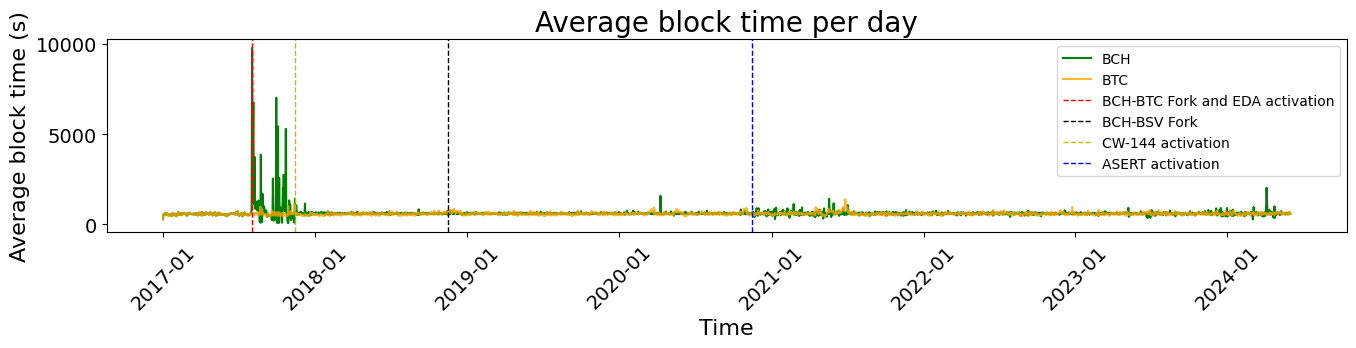

In [49]:
start_date = pd.Timestamp('2017-12-31')
end_date = pd.Timestamp('2021-01-01')

q_res_BCH_avg_block_time['day'] = pd.to_datetime(q_res_BCH_avg_block_time['day'])
q_res_BTC_avg_block_time['day'] = pd.to_datetime(q_res_BTC_avg_block_time['day'])

plt.figure(figsize=(16, 2.5))
plt.plot(q_res_BCH_avg_block_time['day'], q_res_BCH_avg_block_time['avg_block_time'], color='green', label='BCH')
plt.plot(q_res_BTC_avg_block_time['day'], q_res_BTC_avg_block_time['avg_block_time'], color='orange', label='BTC', alpha=0.8)
plt.axvline(pd.Timestamp('2017-08-01'), color='r', linestyle='--', linewidth=1, label='BCH-BTC Fork and EDA activation')
plt.axvline(pd.Timestamp('2018-11-15'), color='black', linestyle='--', linewidth=1, label='BCH-BSV Fork')
plt.axvline(pd.Timestamp('2017-11-13'), color='y', linestyle='--', linewidth=1, label='CW-144 activation')
plt.axvline(pd.Timestamp('2020-11-15'), color='b', linestyle='--', linewidth=1, label='ASERT activation')

plt.title('Average block time per day', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Average block time (s)', fontsize=16)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=14)

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# plt.xlim(start_date, end_date)
# plt.ylim(0, 1000)

plt.xticks(rotation=45)
plt.show()

### Blocks per hour

In [50]:
q_BTC_hour_count = """ 
SELECT 
    strftime('%Y-%m-%d %H:00:00', median_time) AS hour, 
    COUNT(*) AS record_count
FROM 
    df_BTC
GROUP BY 
    hour
ORDER BY 
    hour;
"""

q_BCH_hour_count = """
SELECT
    strftime('%Y-%m-%d %H:00:00', median_time) AS hour,
    COUNT(*) AS record_count
FROM
    df_BCH
GROUP BY
    hour
ORDER BY
    hour;
"""

q_res_BTC_hour_count = ps.sqldf(q_BTC_hour_count, locals())
q_res_BCH_hour_count = ps.sqldf(q_BCH_hour_count, locals())

In [51]:
print('BTC:')
print(q_res_BTC_hour_count['record_count'].describe())
print('BCH:')
print(q_res_BCH_hour_count['record_count'].describe())

BTC:
count    64820.000000
mean         6.170148
std          2.490552
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         21.000000
Name: record_count, dtype: float64
BCH:
count    63927.000000
mean         6.291755
std          4.291642
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         74.000000
Name: record_count, dtype: float64


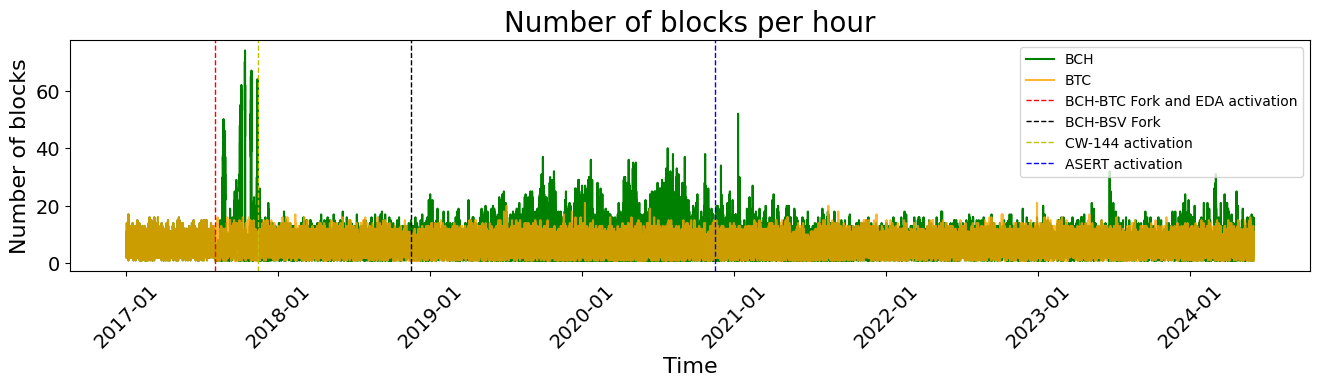

In [52]:
start_date = pd.Timestamp('2017-12-31')
end_date = pd.Timestamp('2021-01-01')

q_res_BCH_hour_count['hour'] = pd.to_datetime(q_res_BCH_hour_count['hour'])
q_res_BTC_hour_count['hour'] = pd.to_datetime(q_res_BTC_hour_count['hour'])

plt.figure(figsize=(16, 3))
plt.plot(q_res_BCH_hour_count['hour'], q_res_BCH_hour_count['record_count'], color='green', label='BCH')
plt.plot(q_res_BTC_hour_count['hour'], q_res_BTC_hour_count['record_count'], color='orange', label='BTC', alpha=0.8)
plt.axvline(pd.Timestamp('2017-08-01'), color='r', linestyle='--', linewidth=1, label='BCH-BTC Fork and EDA activation')
plt.axvline(pd.Timestamp('2018-11-15'), color='black', linestyle='--', linewidth=1, label='BCH-BSV Fork')
plt.axvline(pd.Timestamp('2017-11-13'), color='y', linestyle='--', linewidth=1, label='CW-144 activation')
plt.axvline(pd.Timestamp('2020-11-15'), color='b', linestyle='--', linewidth=1, label='ASERT activation')

plt.title('Number of blocks per hour', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Number of blocks', fontsize=16)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=14)

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# plt.xlim(start_date, end_date)

plt.xticks(rotation=45)
plt.show()

In [53]:
min_hour = q_res_BCH_hour_count['hour'].min()
max_hour = q_res_BCH_hour_count['hour'].max()
print(min_hour, max_hour)
complete_range = pd.date_range(start=min_hour, end=max_hour, freq='h')
complete_df = pd.DataFrame({'hour': complete_range})
q_res_BCH_hour_count = pd.merge(complete_df, q_res_BCH_hour_count, on='hour', how='left').fillna({'record_count': 0})
q_res_BTC_hour_count = pd.merge(complete_df, q_res_BTC_hour_count, on='hour', how='left').fillna({'record_count': 0})

2016-12-31 23:00:00 2024-05-31 22:00:00


Text(0, 0.5, 'Probability Density')

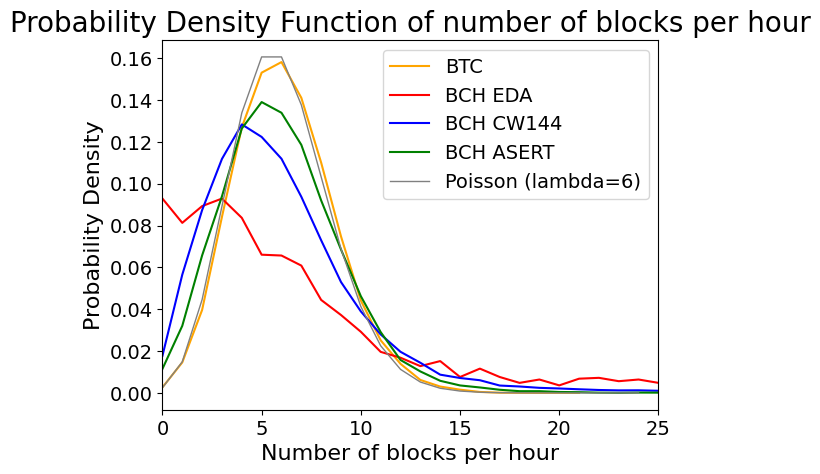

In [54]:
q_res_BCH_hour_count_EDA = q_res_BCH_hour_count[(q_res_BCH_hour_count['hour'] >= '2017-08-01') & (q_res_BCH_hour_count['hour'] <= '2017-11-13')]
q_res_BCH_hour_count_CW144 = q_res_BCH_hour_count[(q_res_BCH_hour_count['hour'] >= '2017-11-13') & (q_res_BCH_hour_count['hour'] <= '2020-11-15')]
q_res_BCH_hour_count_ASERT = q_res_BCH_hour_count[(q_res_BCH_hour_count['hour'] >= '2020-11-15')]

x_lim = 25

BTC_pdf = q_res_BTC_hour_count['record_count'].value_counts(normalize=True).sort_index()
BCH_EDA_pdf = q_res_BCH_hour_count_EDA['record_count'].value_counts(normalize=True).sort_index()
BCH_CW144_pdf = q_res_BCH_hour_count_CW144['record_count'].value_counts(normalize=True).sort_index()
BCH_ASERT_pdf = q_res_BCH_hour_count_ASERT['record_count'].value_counts(normalize=True).sort_index()

x_lim = 25
plt.plot(BTC_pdf.index, BTC_pdf.values, color='orange', label='BTC')
plt.plot(BCH_EDA_pdf.index, BCH_EDA_pdf.values, color='red', label='BCH EDA')
plt.plot(BCH_CW144_pdf.index, BCH_CW144_pdf.values, color='blue', label='BCH CW144')
plt.plot(BCH_ASERT_pdf.index, BCH_ASERT_pdf.values, color='green', label='BCH ASERT')
plt.plot(poisson.pmf(np.arange(0, x_lim), 6), color='gray', label='Poisson (lambda=6)', linewidth=1)
plt.xlim(0, x_lim) 
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=14)
plt.title('Probability Density Function of number of blocks per hour', fontsize=20)
plt.xlabel('Number of blocks per hour', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)

### Difficulty

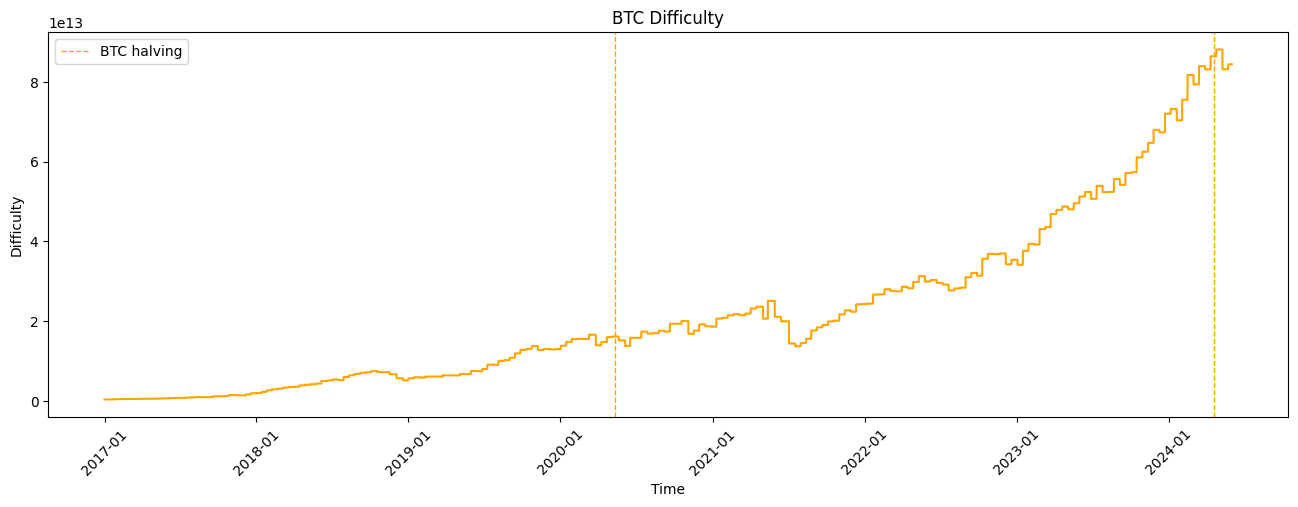

In [55]:
df_BTC['time'] = pd.to_datetime(df_BTC['time'])

plt.figure(figsize=(16, 5))
plt.plot(df_BTC['time'], df_BTC['difficulty'], color='orange')

plt.title('BTC Difficulty')
plt.xlabel('Time')
plt.ylabel('Difficulty')

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.axvline(pd.Timestamp('2020-05-11'), color='orange', linestyle='--', linewidth=1, label='BTC halving')
plt.axvline(pd.Timestamp('2024-04-20'), color='orange', linestyle='--', linewidth=1)
plt.xticks(rotation=45)

plt.legend()
plt.show()

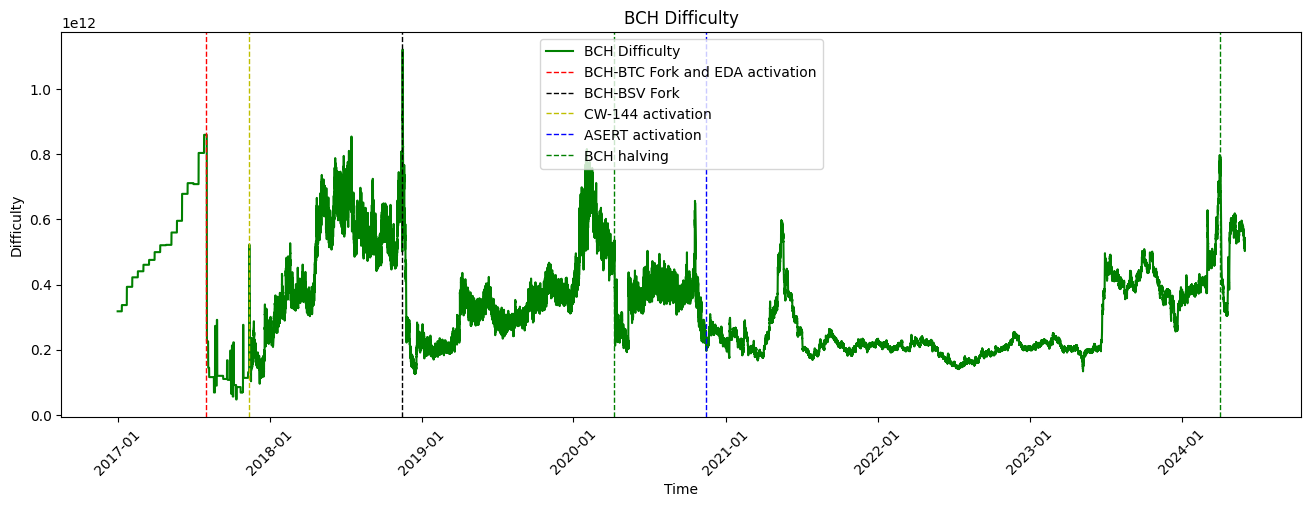

In [56]:
df_BCH['time'] = pd.to_datetime(df_BCH['time'])

plt.figure(figsize=(16, 5))
plt.plot(df_BCH['time'], df_BCH['difficulty'], color='green', label='BCH Difficulty')

plt.axvline(pd.Timestamp('2017-08-01'), color='r', linestyle='--', linewidth=1, label='BCH-BTC Fork and EDA activation')
plt.axvline(pd.Timestamp('2018-11-15'), color='black', linestyle='--', linewidth=1, label='BCH-BSV Fork')
plt.axvline(pd.Timestamp('2017-11-13'), color='y', linestyle='--', linewidth=1, label='CW-144 activation')
plt.axvline(pd.Timestamp('2020-11-15'), color='b', linestyle='--', linewidth=1, label='ASERT activation')
plt.axvline(pd.Timestamp('2020-04-08'), color='green', linestyle='--', linewidth=1, label='BCH halving')
plt.axvline(pd.Timestamp('2024-04-03'), color='green', linestyle='--', linewidth=1)

plt.title('BCH Difficulty')
plt.xlabel('Time')
plt.ylabel('Difficulty')
plt.legend()

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

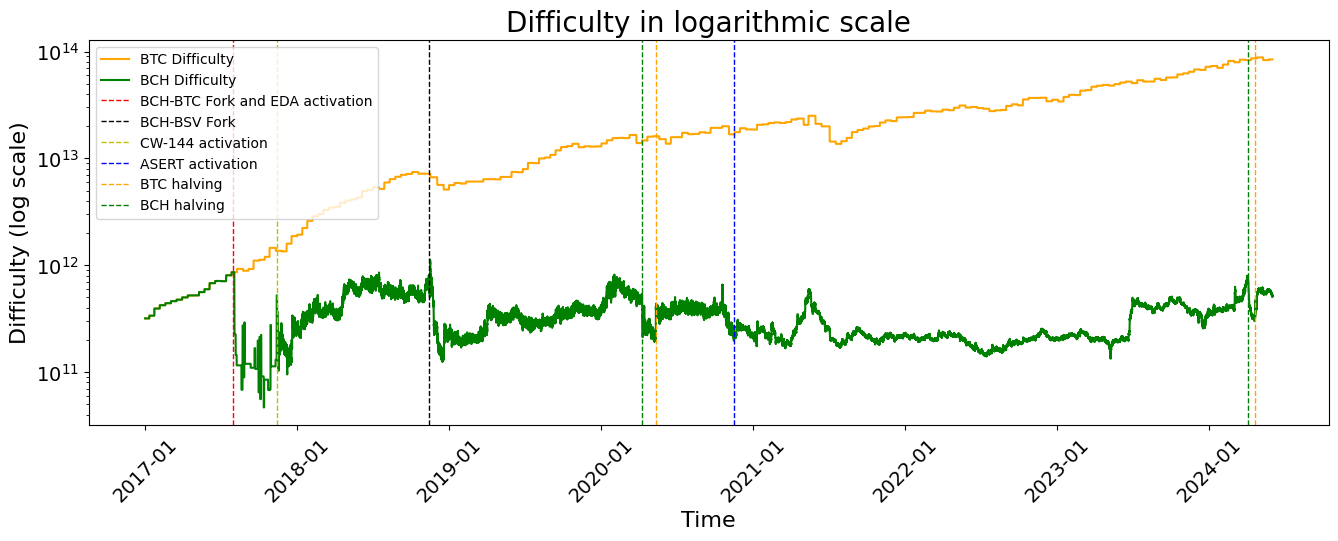

In [57]:
df_BCH['time'] = pd.to_datetime(df_BCH['time'])

plt.figure(figsize=(16, 5))
plt.plot(df_BTC['time'], df_BTC['difficulty'], color='orange', label='BTC Difficulty')
plt.plot(df_BCH['time'], df_BCH['difficulty'], color='green', label='BCH Difficulty')

plt.axvline(pd.Timestamp('2017-08-01'), color='r', linestyle='--', linewidth=1, label='BCH-BTC Fork and EDA activation')
plt.axvline(pd.Timestamp('2018-11-15'), color='black', linestyle='--', linewidth=1, label='BCH-BSV Fork')
plt.axvline(pd.Timestamp('2017-11-13'), color='y', linestyle='--', linewidth=1, label='CW-144 activation')
plt.axvline(pd.Timestamp('2020-11-15'), color='b', linestyle='--', linewidth=1, label='ASERT activation')
plt.axvline(pd.Timestamp('2020-05-11'), color='orange', linestyle='--', linewidth=1, label='BTC halving')
plt.axvline(pd.Timestamp('2024-04-20'), color='orange', linestyle='--', linewidth=1)
plt.axvline(pd.Timestamp('2020-04-08'), color='green', linestyle='--', linewidth=1, label='BCH halving')
plt.axvline(pd.Timestamp('2024-04-03'), color='green', linestyle='--', linewidth=1)

plt.title('Difficulty in logarithmic scale', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Difficulty (log scale)', fontsize=16)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=14)

plt.yscale('log')

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

### Hash rate

https://hashrateindex.com/blog/what-is-bitcoins-hashrate/

https://www.coinwarz.com/mining/bitcoincash/hashrate-chart

https://www.coinwarz.com/mining/bitcoin/hashrate-chart

https://bitinfocharts.com/comparison/bitcoin%20cash-hashrate.html


<strong>Estimated daily hash rate = (#blocks solved over last 24 hrs/144) * difficulty * 2^32 /600</strong>

144 = ideal # blocks per day

difficulty * 2^32 = avg amount of hashes (work) to solve a block

/600 to convert to hashes per second

In [58]:
q_BCH_hash_rate_data = """
SELECT
    strftime('%Y-%m-%d 00:00:00', median_time) AS day,
    COUNT(*) AS block_count,
    AVG(difficulty) AS avg_difficulty
FROM
    df_BCH
GROUP BY
    day
ORDER BY
    day;
"""

q_BTC_hash_rate_data = """
SELECT
    strftime('%Y-%m-%d 00:00:00', median_time) AS day,
    COUNT(*) AS block_count,
    AVG(difficulty) AS avg_difficulty
FROM
    df_BTC
GROUP BY
    day
ORDER BY
    day;
"""

q_res_BCH_hash_rate_data = ps.sqldf(q_BCH_hash_rate_data, locals())
q_res_BTC_hash_rate_data = ps.sqldf(q_BTC_hash_rate_data, locals())

q_res_BCH_hash_rate_data["daily_hash_rate"] = (q_res_BCH_hash_rate_data['block_count'] / 144) * q_res_BCH_hash_rate_data['avg_difficulty'] * 2**32 / 600 
q_res_BTC_hash_rate_data["daily_hash_rate"] = (q_res_BTC_hash_rate_data['block_count'] / 144) * q_res_BTC_hash_rate_data['avg_difficulty'] * 2**32 / 600

In [59]:
print("BTC:")
print(q_res_BTC_hash_rate_data.describe())
print("BCH:")
print(q_res_BCH_hash_rate_data.describe())

BTC:
       block_count  avg_difficulty  daily_hash_rate
count  2709.000000    2.709000e+03     2.709000e+03
mean    147.637135    2.258043e+13     1.641102e+20
std      16.353534    2.160797e+13     1.584720e+20
min       5.000000    3.176884e+11     7.896188e+16
25%     138.000000    6.068892e+12     4.347498e+19
50%     148.000000    1.678778e+13     1.199365e+20
75%     158.000000    2.989741e+13     2.205152e+20
max     197.000000    8.810419e+13     7.214590e+20
BCH:
       block_count  avg_difficulty  daily_hash_rate
count  2709.000000    2.709000e+03     2.709000e+03
mean    148.472868    3.342877e+11     2.418740e+18
std      59.501186    1.538134e+11     1.162532e+18
min       5.000000    4.734111e+10     5.899394e+16
25%     138.000000    2.087417e+11     1.501091e+18
50%     145.000000    3.109552e+11     2.190168e+18
75%     150.000000    4.198264e+11     3.020803e+18
max    1254.000000    8.926231e+11     7.509006e+18


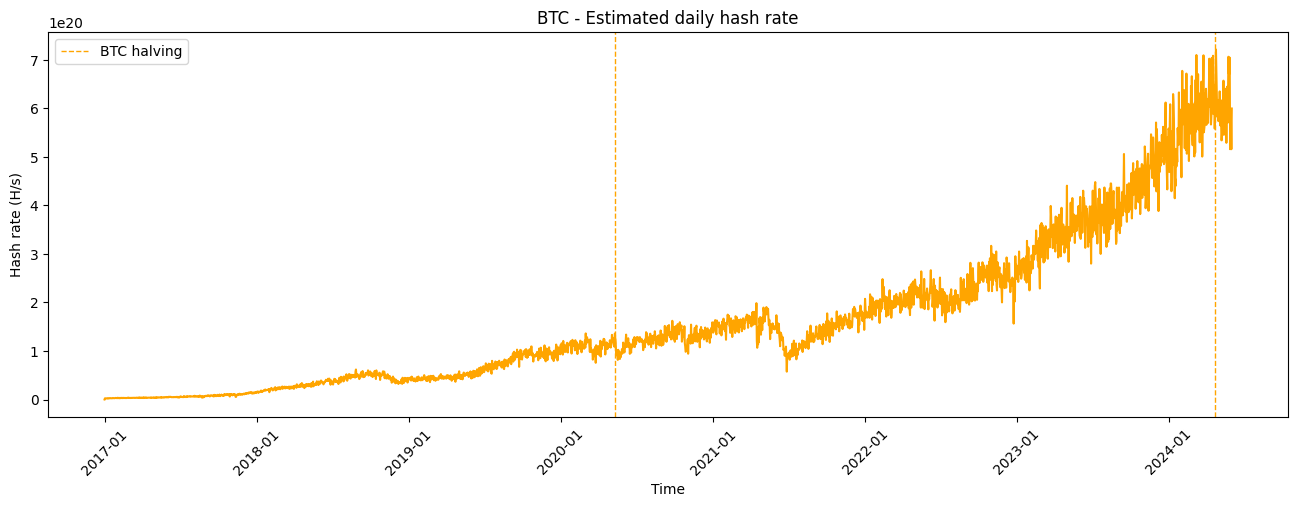

In [60]:
start_date = pd.Timestamp('2017-12-31')
end_date = pd.Timestamp('2021-01-01')

q_res_BCH_hash_rate_data['day'] = pd.to_datetime(q_res_BCH_hash_rate_data['day'])
q_res_BTC_hash_rate_data['day'] = pd.to_datetime(q_res_BTC_hash_rate_data['day'])


plt.figure(figsize=(16, 5))
plt.plot(q_res_BTC_hash_rate_data['day'], q_res_BTC_hash_rate_data['daily_hash_rate'], color='orange')
plt.axvline(pd.Timestamp('2020-05-11'), color='orange', linestyle='--', linewidth=1, label='BTC halving')
plt.axvline(pd.Timestamp('2024-04-20'), color='orange', linestyle='--', linewidth=1)

plt.title('BTC - Estimated daily hash rate')
plt.xlabel('Time')
plt.ylabel('Hash rate (H/s)')
plt.legend()

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# plt.xlim(start_date, end_date)

plt.xticks(rotation=45)
plt.show()

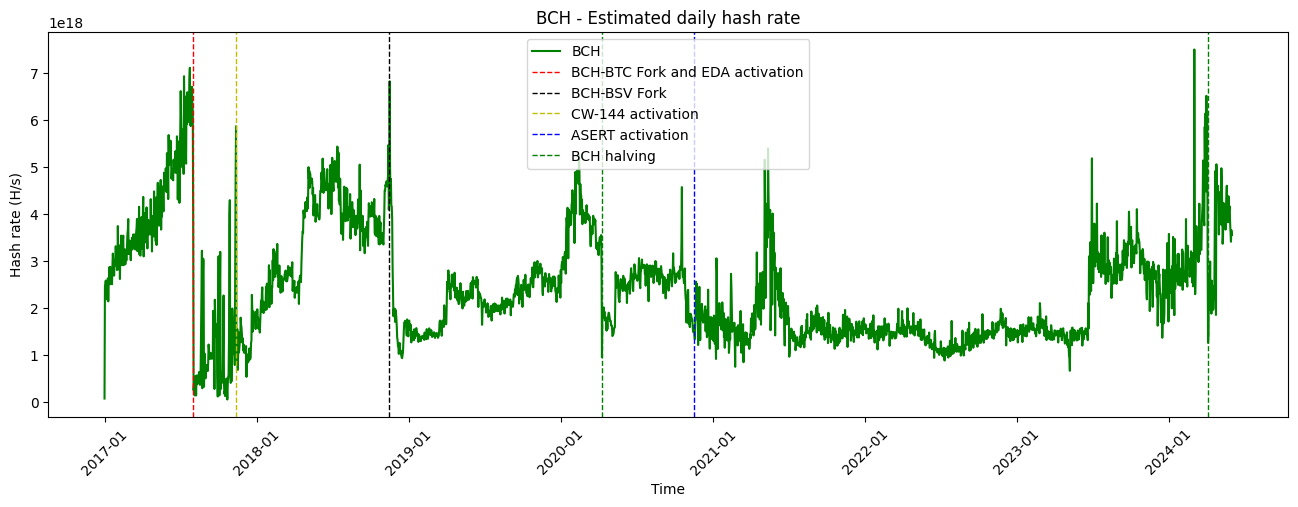

In [61]:
start_date = pd.Timestamp('2017-12-31')
end_date = pd.Timestamp('2021-01-01')

q_res_BCH_hash_rate_data['day'] = pd.to_datetime(q_res_BCH_hash_rate_data['day'])
q_res_BTC_hash_rate_data['day'] = pd.to_datetime(q_res_BTC_hash_rate_data['day'])


plt.figure(figsize=(16, 5))
plt.plot(q_res_BCH_hash_rate_data['day'], q_res_BCH_hash_rate_data['daily_hash_rate'], color='green', label='BCH')
plt.axvline(pd.Timestamp('2017-08-01'), color='r', linestyle='--', linewidth=1, label='BCH-BTC Fork and EDA activation')
plt.axvline(pd.Timestamp('2018-11-15'), color='black', linestyle='--', linewidth=1, label='BCH-BSV Fork')
plt.axvline(pd.Timestamp('2017-11-13'), color='y', linestyle='--', linewidth=1, label='CW-144 activation')
plt.axvline(pd.Timestamp('2020-11-15'), color='b', linestyle='--', linewidth=1, label='ASERT activation')
plt.axvline(pd.Timestamp('2020-04-08'), color='green', linestyle='--', linewidth=1, label='BCH halving')
plt.axvline(pd.Timestamp('2024-04-03'), color='green', linestyle='--', linewidth=1)

plt.title('BCH - Estimated daily hash rate')
plt.xlabel('Time')
plt.ylabel('Hash rate (H/s)')
plt.legend()

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# plt.xlim(start_date, end_date)

plt.xticks(rotation=45)
plt.show()

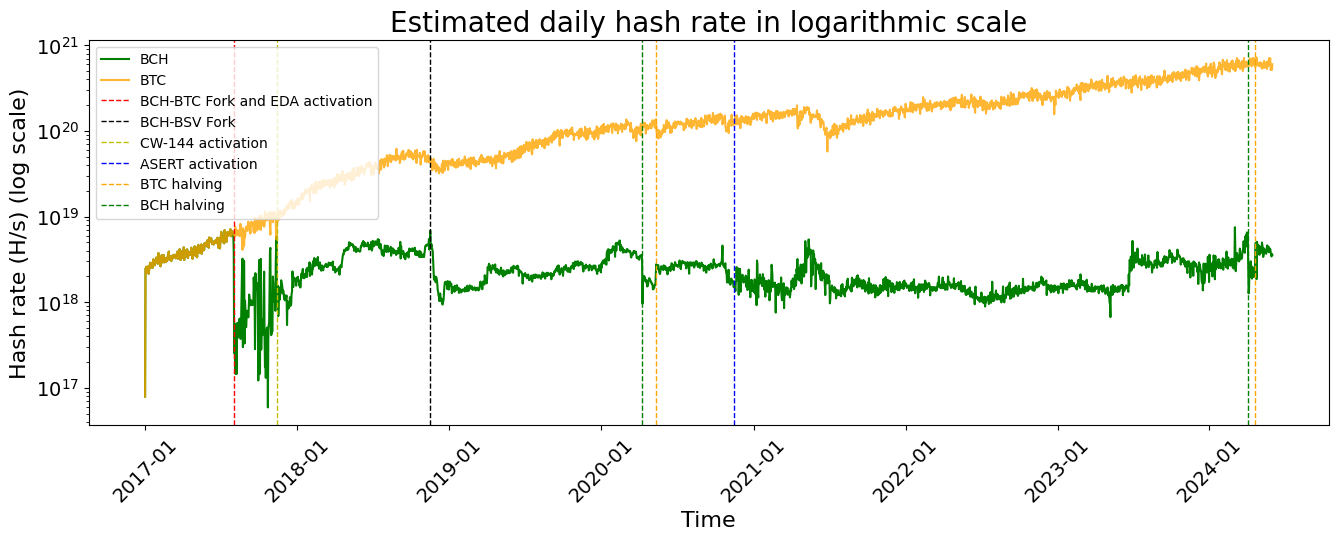

In [62]:
start_date = pd.Timestamp('2020-12-31')
end_date = pd.Timestamp('2024-01-01')

q_res_BCH_hash_rate_data['day'] = pd.to_datetime(q_res_BCH_hash_rate_data['day'])
q_res_BTC_hash_rate_data['day'] = pd.to_datetime(q_res_BTC_hash_rate_data['day'])


plt.figure(figsize=(16, 5))
plt.plot(q_res_BCH_hash_rate_data['day'], q_res_BCH_hash_rate_data['daily_hash_rate'], color='green', label='BCH')
plt.plot(q_res_BTC_hash_rate_data['day'], q_res_BTC_hash_rate_data['daily_hash_rate'], color='orange', label='BTC', alpha=0.8)
plt.axvline(pd.Timestamp('2017-08-01'), color='r', linestyle='--', linewidth=1, label='BCH-BTC Fork and EDA activation')
plt.axvline(pd.Timestamp('2018-11-15'), color='black', linestyle='--', linewidth=1, label='BCH-BSV Fork')
plt.axvline(pd.Timestamp('2017-11-13'), color='y', linestyle='--', linewidth=1, label='CW-144 activation')
plt.axvline(pd.Timestamp('2020-11-15'), color='b', linestyle='--', linewidth=1, label='ASERT activation')
plt.axvline(pd.Timestamp('2020-05-11'), color='orange', linestyle='--', linewidth=1, label='BTC halving')
plt.axvline(pd.Timestamp('2024-04-20'), color='orange', linestyle='--', linewidth=1)
plt.axvline(pd.Timestamp('2020-04-08'), color='green', linestyle='--', linewidth=1, label='BCH halving')
plt.axvline(pd.Timestamp('2024-04-03'), color='green', linestyle='--', linewidth=1)

plt.title('Estimated daily hash rate in logarithmic scale', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Hash rate (H/s) (log scale)', fontsize=16)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=14)

plt.yscale('log')

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# plt.xlim(start_date, end_date)

plt.xticks(rotation=45)
plt.show()

In [63]:
q_res_BCH_hash_rate_data['daily_hash_rate'].to_csv('out.csv', index=False)

### Autocorellation

https://www.investopedia.com/terms/a/autocorrelation.asp

#### Autocorellation of number of blocks per hour

In [64]:
BTC_hour_count_acf_values = acf(q_res_BTC_hour_count['record_count'], nlags=100)
BCH_hour_count_EDA_acf_values = acf(q_res_BCH_hour_count_EDA['record_count'], nlags=100)
BCH_hour_count_CW144_acf_values = acf(q_res_BCH_hour_count_CW144['record_count'], nlags=100)
BCH_hour_count_ASERT_acf_values = acf(q_res_BCH_hour_count_ASERT['record_count'], nlags=100)

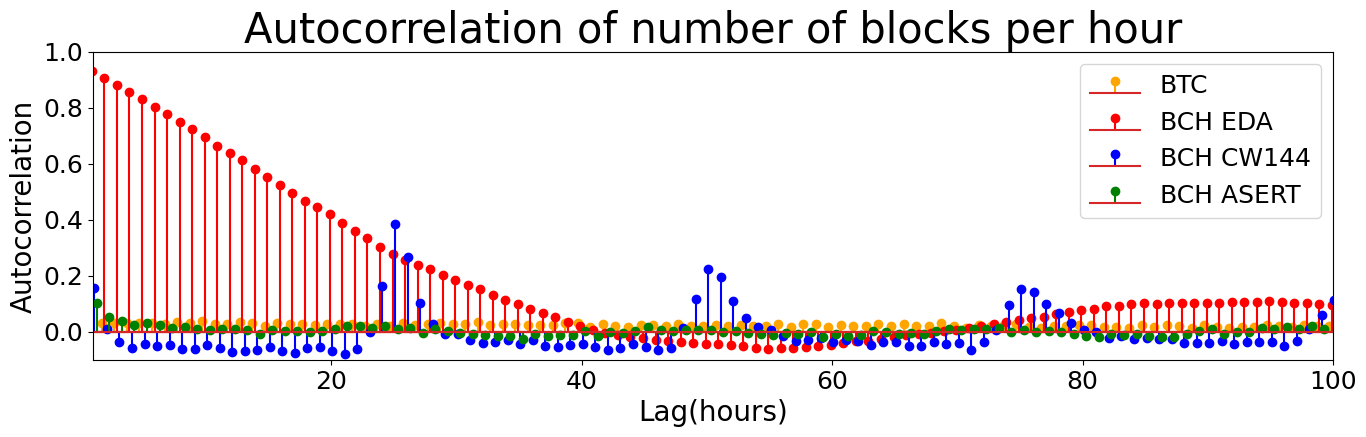

In [65]:
lags = np.arange(0, 101)
width = 0.2
plt.stem(lags - 1.5 * width, BTC_hour_count_acf_values, label='BTC', linefmt='orange')
plt.stem(lags - 0.5 * width, BCH_hour_count_EDA_acf_values, label='BCH EDA', linefmt='red')
plt.stem(lags + 0.5 * width, BCH_hour_count_CW144_acf_values, label='BCH CW144', linefmt='blue')
plt.stem(lags + 1.5 * width, BCH_hour_count_ASERT_acf_values, label='BCH ASERT', linefmt='green')
plt.title('Autocorrelation of number of blocks per hour', fontsize=30)
plt.xlabel('Lag(hours)', fontsize=20)
plt.ylabel('Autocorrelation', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.gcf().set_size_inches(16, 4)
plt.legend(fontsize=18)
plt.ylim(-0.1, 1)
plt.xlim(1, 100)
plt.show()

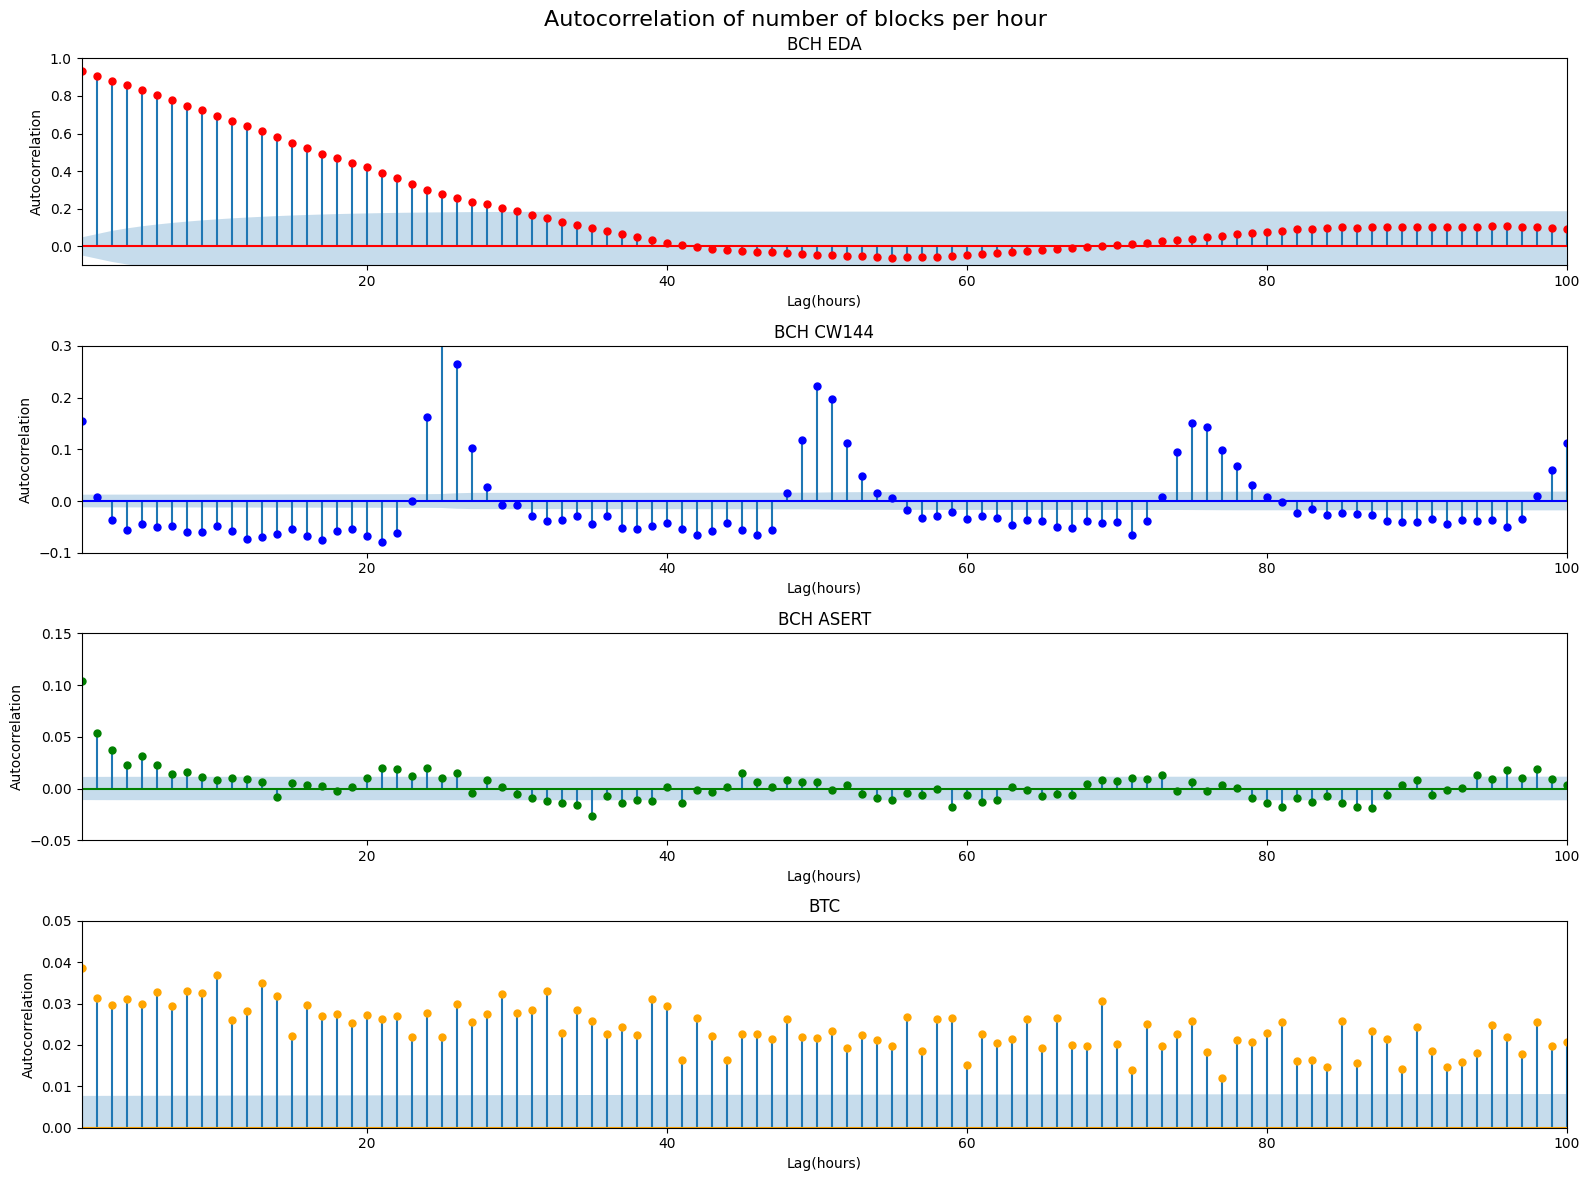

In [66]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(4, 1, figsize=(16, 12))

plot_acf(q_res_BCH_hour_count_EDA['record_count'], lags=100, ax=axs[0], color='red')
axs[0].set_title('BCH EDA')
axs[0].set_xlabel('Lag(hours)')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xlim(1, 100)
axs[0].set_ylim(-0.1, 1)

plot_acf(q_res_BCH_hour_count_CW144['record_count'], lags=100, ax=axs[1], color='blue')
axs[1].set_title('BCH CW144')
axs[1].set_xlabel('Lag(hours)')
axs[1].set_ylabel('Autocorrelation')
axs[1].set_xlim(1, 100)
axs[1].set_ylim(-0.1, 0.3)

plot_acf(q_res_BCH_hour_count_ASERT['record_count'], lags=100, ax=axs[2], color='green')
axs[2].set_title('BCH ASERT')
axs[2].set_xlabel('Lag(hours)')
axs[2].set_ylabel('Autocorrelation')
axs[2].set_xlim(1, 100)
axs[2].set_ylim(-0.05, 0.15)

plot_acf(q_res_BTC_hour_count['record_count'], lags=100, ax=axs[3], color='orange')
axs[3].set_title('BTC')
axs[3].set_xlabel('Lag(hours)')
axs[3].set_ylabel('Autocorrelation')
axs[3].set_xlim(1, 100)
axs[3].set_ylim(0, 0.05)

fig.suptitle('Autocorrelation of number of blocks per hour', fontsize=16)
plt.tight_layout()
plt.show()


#### Autocorellation of block times

In [67]:
BTC_block_times_acf_values = acf(df_BTC['block_time'], nlags=200)
BCH_block_times_EDA_acf_values = acf(df_BCH_EDA['block_time'], nlags=200)
BCH_block_times_CW144_acf_values = acf(df_BCH_CW144['block_time'], nlags=200)
BCH_block_times_ASERT_acf_values = acf(df_BCH_ASERT['block_time'], nlags=200)

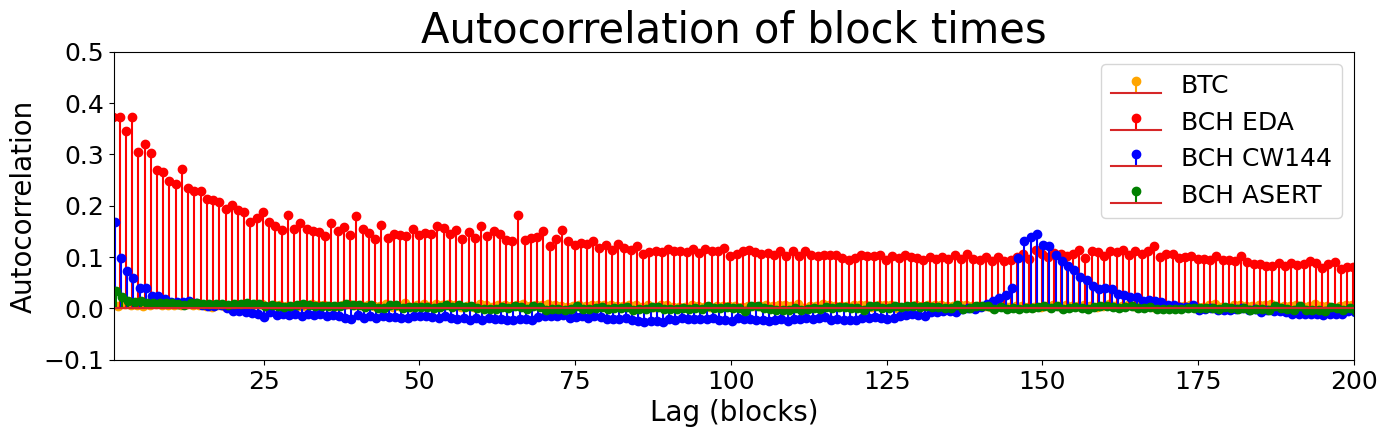

In [68]:
lags = np.arange(0, 201)
width = 0.2
plt.stem(lags - 1.5 * width, BTC_block_times_acf_values, label='BTC', linefmt='orange')
plt.stem(lags - 0.5 * width, BCH_block_times_EDA_acf_values, label='BCH EDA', linefmt='red')
plt.stem(lags + 0.5 * width, BCH_block_times_CW144_acf_values, label='BCH CW144', linefmt='blue')
plt.stem(lags + 1.5 * width, BCH_block_times_ASERT_acf_values, label='BCH ASERT', linefmt='green')
plt.title('Autocorrelation of block times', fontsize=30)
plt.xlabel('Lag (blocks)', fontsize=20)
plt.ylabel('Autocorrelation', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.gcf().set_size_inches(16, 4)
plt.legend(fontsize=18)
plt.ylim(-0.1, 0.5)
plt.xlim(1, 200)
plt.show()

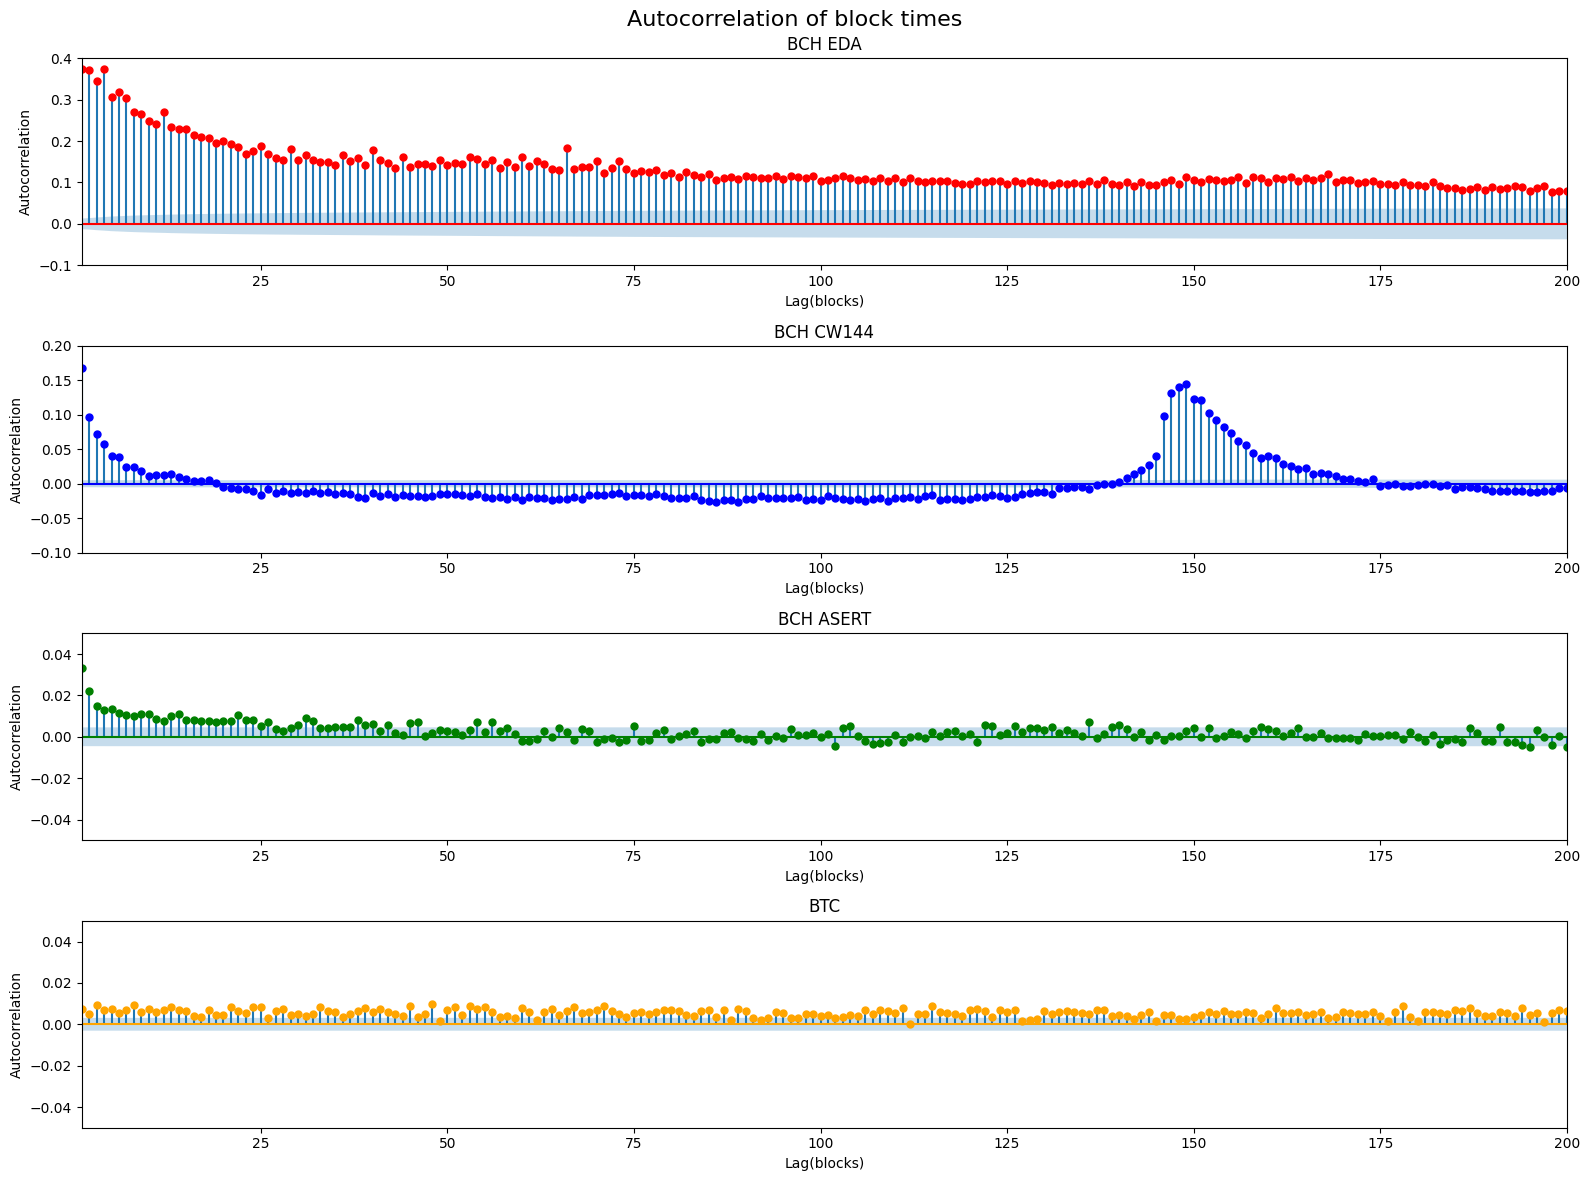

In [69]:
fig, axs = plt.subplots(4, 1, figsize=(16, 12))

plot_acf(df_BCH_EDA['block_time'], lags=200, ax=axs[0], color='red')
axs[0].set_title('BCH EDA')
axs[0].set_xlabel('Lag(blocks)')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xlim(1, 200)
axs[0].set_ylim(-0.1, 0.4)

plot_acf(df_BCH_CW144['block_time'], lags=200, ax=axs[1], color='blue')
axs[1].set_title('BCH CW144')
axs[1].set_xlabel('Lag(blocks)')
axs[1].set_ylabel('Autocorrelation')
axs[1].set_xlim(1, 200)
axs[1].set_ylim(-0.1, 0.2)

plot_acf(df_BCH_ASERT['block_time'], lags=200, ax=axs[2], color='green')
axs[2].set_title('BCH ASERT')
axs[2].set_xlabel('Lag(blocks)')
axs[2].set_ylabel('Autocorrelation')
axs[2].set_xlim(1, 200)
axs[2].set_ylim(-0.05, 0.05)

plot_acf(df_BTC['block_time'], lags=200, ax=axs[3], color='orange')
axs[3].set_title('BTC')
axs[3].set_xlabel('Lag(blocks)')
axs[3].set_ylabel('Autocorrelation')
axs[3].set_xlim(1, 200)
axs[3].set_ylim(-0.05, 0.05)

fig.suptitle('Autocorrelation of block times', fontsize=16)
plt.tight_layout()
plt.show()

## Simulation Data

In [112]:
from statistics import mean
from statistics import stdev
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prettytable import PrettyTable
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import seaborn as sns
from scipy.stats import poisson
from datetime import datetime

In [113]:
df_modified = pd.read_csv('data/MODIFIED_NEFDA_Output.csv')
df_non_modified = pd.read_csv('data/NEFDA_Output.csv')
df_modified['timestamp'] -= 62168450400 
df_modified['median_time'] = pd.to_datetime(df_modified['timestamp'], unit='s')
df_non_modified['timestamp'] -= 62168450400
df_non_modified['median_time'] = pd.to_datetime(df_non_modified['timestamp'], unit='s')

### Block times

In [114]:
print('Non Modified:')
print('mean:',df_non_modified['block_time'].mean())
print('stdev:',df_non_modified['block_time'].std())
print('Modified:')
print('mean:',df_modified['block_time'].mean())
print('stdev:',df_modified['block_time'].std())

# sanity check
df_non_modified['secondary_block_time'] = pd.to_datetime(df_non_modified['median_time']).diff().dt.total_seconds().fillna(0)
df_modified['secondary_block_time'] = pd.to_datetime(df_modified['median_time']).diff().dt.total_seconds().fillna(0)
print(df_non_modified['block_time'][1:].equals(df_non_modified['secondary_block_time'][1:]))
print(df_modified['block_time'][1:].equals(df_modified['secondary_block_time'][1:]))

q_non_modified_avg_block_time = """
SELECT
    strftime('%Y-%m-%d 00:00:00', median_time) AS day,
    AVG(block_time) AS avg_block_time
FROM
    df_non_modified
GROUP BY
    day
ORDER BY
    day;
"""

q_modified_avg_block_time = """
SELECT
    strftime('%Y-%m-%d 00:00:00', median_time) AS day,
    AVG(block_time) AS avg_block_time
FROM
    df_modified
GROUP BY
    day
ORDER BY
    day;
"""


q_non_modified_hour_count = """ 
SELECT 
    strftime('%Y-%m-%d %H:00:00', median_time) AS hour, 
    COUNT(*) AS record_count
FROM 
    df_non_modified
GROUP BY 
    hour
ORDER BY 
    hour;
"""

q_modified_hour_count = """
SELECT
    strftime('%Y-%m-%d %H:00:00', median_time) AS hour,
    COUNT(*) AS record_count
FROM
    df_modified
GROUP BY
    hour
ORDER BY
    hour;
"""

q_res_non_modified_avg_block_time = ps.sqldf(q_non_modified_avg_block_time, locals())
q_res_modified_avg_block_time = ps.sqldf(q_modified_avg_block_time, locals())
q_res_non_modified_hour_count = ps.sqldf(q_non_modified_hour_count, locals())
q_res_modified_hour_count = ps.sqldf(q_modified_hour_count, locals())

q_res_non_modified_avg_block_time['day'] = pd.to_datetime(q_res_non_modified_avg_block_time['day'])
q_res_modified_avg_block_time['day'] = pd.to_datetime(q_res_modified_avg_block_time['day'])
q_res_non_modified_hour_count['hour'] = pd.to_datetime(q_res_non_modified_hour_count['hour'])
q_res_modified_hour_count['hour'] = pd.to_datetime(q_res_modified_hour_count['hour'])

min_hour = q_res_non_modified_hour_count['hour'].min()
max_hour = q_res_non_modified_hour_count['hour'].max()
complete_range = pd.date_range(start=min_hour, end=max_hour, freq='h')
complete_df = pd.DataFrame({'hour': complete_range})
q_res_non_modified_hour_count = pd.merge(complete_df, q_res_non_modified_hour_count, on='hour', how='left').fillna({'record_count': 0})
q_res_modified_hour_count = pd.merge(complete_df, q_res_modified_hour_count, on='hour', how='left').fillna({'record_count': 0})



Non Modified:
mean: 594.1848399948786
stdev: 597.7500007119573
Modified:
mean: 599.9985157393735
stdev: 602.4081882981166
True
True


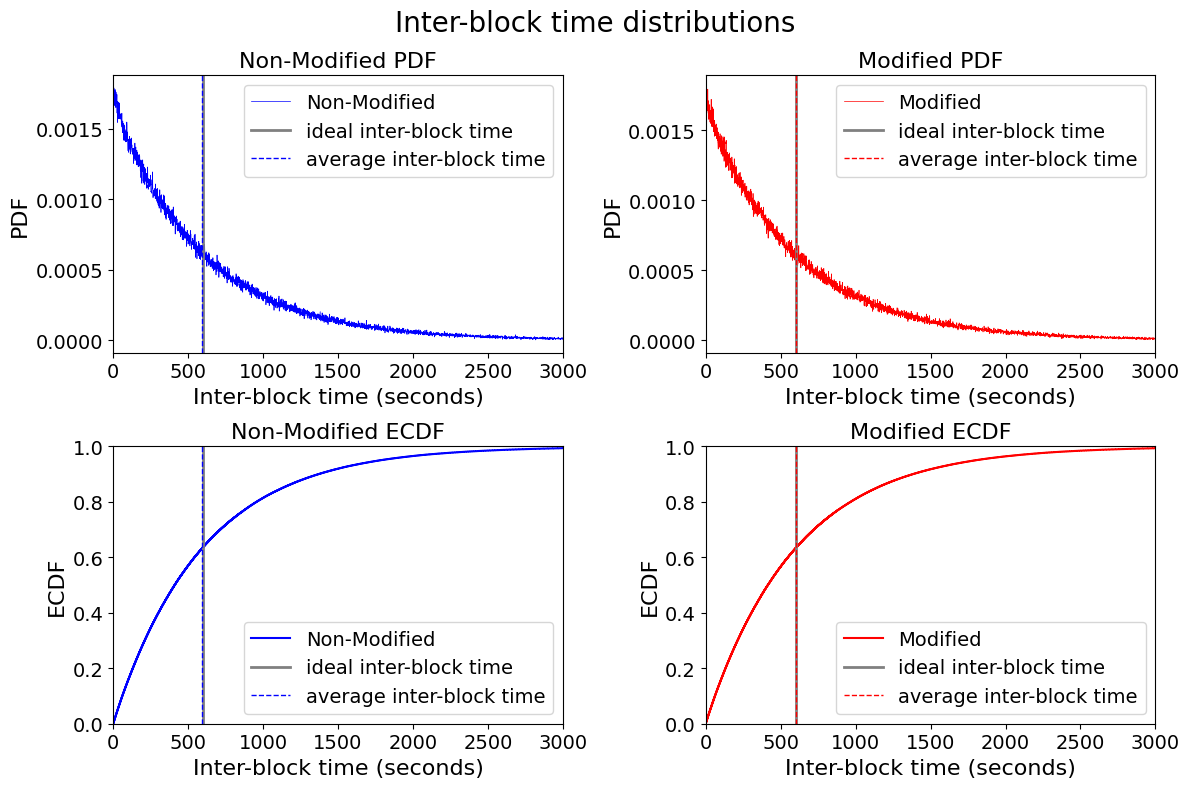

In [115]:
non_modified_pdf_block_time = df_non_modified['block_time'].value_counts(normalize=True).sort_index()
modified_pdf_block_time = df_modified['block_time'].value_counts(normalize=True).sort_index()

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(non_modified_pdf_block_time.index, non_modified_pdf_block_time.values, color='blue', label='Non-Modified', linewidth=0.5)
# axs[0, 0].hist(df_non_modified['block_time'], histtype='step', bins=3000, density=True, color='blue', label='Non-Modified')
axs[0, 0].axvline(600, color='gray', linestyle='-', linewidth=2, label='ideal inter-block time')
axs[0, 0].axvline(df_non_modified['block_time'].mean(), color='blue', linestyle='--', linewidth=1, label='average inter-block time')
axs[0, 0].set_title('Non-Modified PDF', fontsize=16)
axs[0, 0].set_xlabel('Inter-block time (seconds)', fontsize=16)
axs[0, 0].set_ylabel('PDF', fontsize=16)
axs[0, 0].set_xlim(0, 3000)
axs[0, 0].legend(fontsize=14)
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)

axs[0, 1].plot(modified_pdf_block_time.index, modified_pdf_block_time.values, color='red', label='Modified', linewidth=0.5)
# axs[0, 1].hist(df_modified['block_time'], histtype='step', bins=3000, density=True, color='red', label='Modified')
axs[0, 1].axvline(600, color='gray', linestyle='-', linewidth=2, label='ideal inter-block time')
axs[0, 1].axvline(df_modified['block_time'].mean(), color='red', linestyle='--', linewidth=1, label='average inter-block time')
axs[0, 1].set_title('Modified PDF', fontsize=16)
axs[0, 1].set_xlabel('Inter-block time (seconds)', fontsize=16)
axs[0, 1].set_ylabel('PDF', fontsize=16)
axs[0, 1].set_xlim(0, 3000)
axs[0, 1].legend(fontsize=14)
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)

sns.ecdfplot(df_non_modified['block_time'], ax=axs[1, 0], color='blue', label='Non-Modified')
axs[1, 0].axvline(600, color='gray', linestyle='-', linewidth=2, label='ideal inter-block time')
axs[1, 0].axvline(df_non_modified['block_time'].mean(), color='blue', linestyle='--', linewidth=1, label='average inter-block time')
axs[1, 0].set_title('Non-Modified ECDF', fontsize=16)
axs[1, 0].set_xlabel('Inter-block time (seconds)', fontsize=16)
axs[1, 0].set_ylabel('ECDF', fontsize=16)
axs[1, 0].set_xlim(0, 3000)
axs[1, 0].legend(fontsize=14)
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)

sns.ecdfplot(df_modified['block_time'], ax=axs[1, 1], color='red', label='Modified')
axs[1, 1].axvline(600, color='gray', linestyle='-', linewidth=2, label='ideal inter-block time')
axs[1, 1].axvline(df_modified['block_time'].mean(), color='red', linestyle='--', linewidth=1, label='average inter-block time')
axs[1, 1].set_title('Modified ECDF', fontsize=16)
axs[1, 1].set_xlabel('Inter-block time (seconds)', fontsize=16)
axs[1, 1].set_ylabel('ECDF', fontsize=16)
axs[1, 1].set_xlim(0, 3000)
axs[1, 1].legend(fontsize=14)
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle('Inter-block time distributions', fontsize=20)
plt.tight_layout()
plt.show()


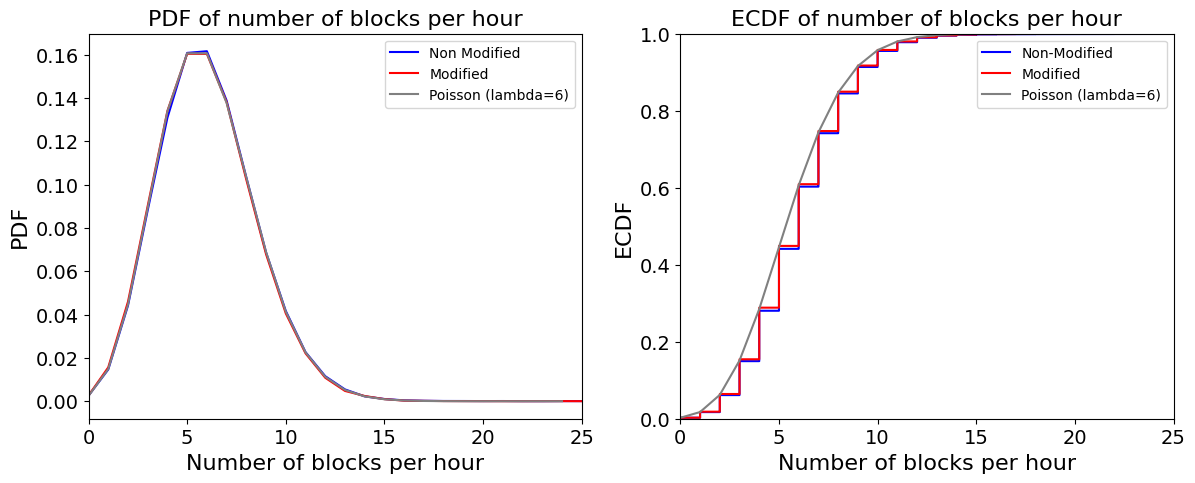

In [116]:
non_modified_pdf = q_res_non_modified_hour_count['record_count'].value_counts(normalize=True).sort_index()
modified_pdf = q_res_modified_hour_count['record_count'].value_counts(normalize=True).sort_index()

x_lim = 25

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(non_modified_pdf.index, non_modified_pdf.values, color='blue', label='Non Modified')
axs[0].plot(modified_pdf.index, modified_pdf.values, color='red', label='Modified')
axs[0].plot(poisson.pmf(np.arange(0, x_lim), 6), color='gray', label='Poisson (lambda=6)')
axs[0].set_xlim(0, x_lim)
axs[0].legend()
axs[0].set_title('PDF of number of blocks per hour', fontsize=16)
axs[0].set_xlabel('Number of blocks per hour', fontsize=16)
axs[0].set_ylabel('PDF', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)

sns.ecdfplot(q_res_non_modified_hour_count['record_count'], ax=axs[1], color='blue', label='Non-Modified')
sns.ecdfplot(q_res_modified_hour_count['record_count'], ax=axs[1], color='red', label='Modified')
axs[1].plot(poisson.cdf(np.arange(0, x_lim), 6), color='gray', label='Poisson (lambda=6)')
axs[1].set_xlim(0, x_lim)
axs[1].legend()
axs[1].set_title('ECDF of number of blocks per hour', fontsize=16)
axs[1].set_xlabel('Number of blocks per hour', fontsize=16)
axs[1].set_ylabel('ECDF', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)


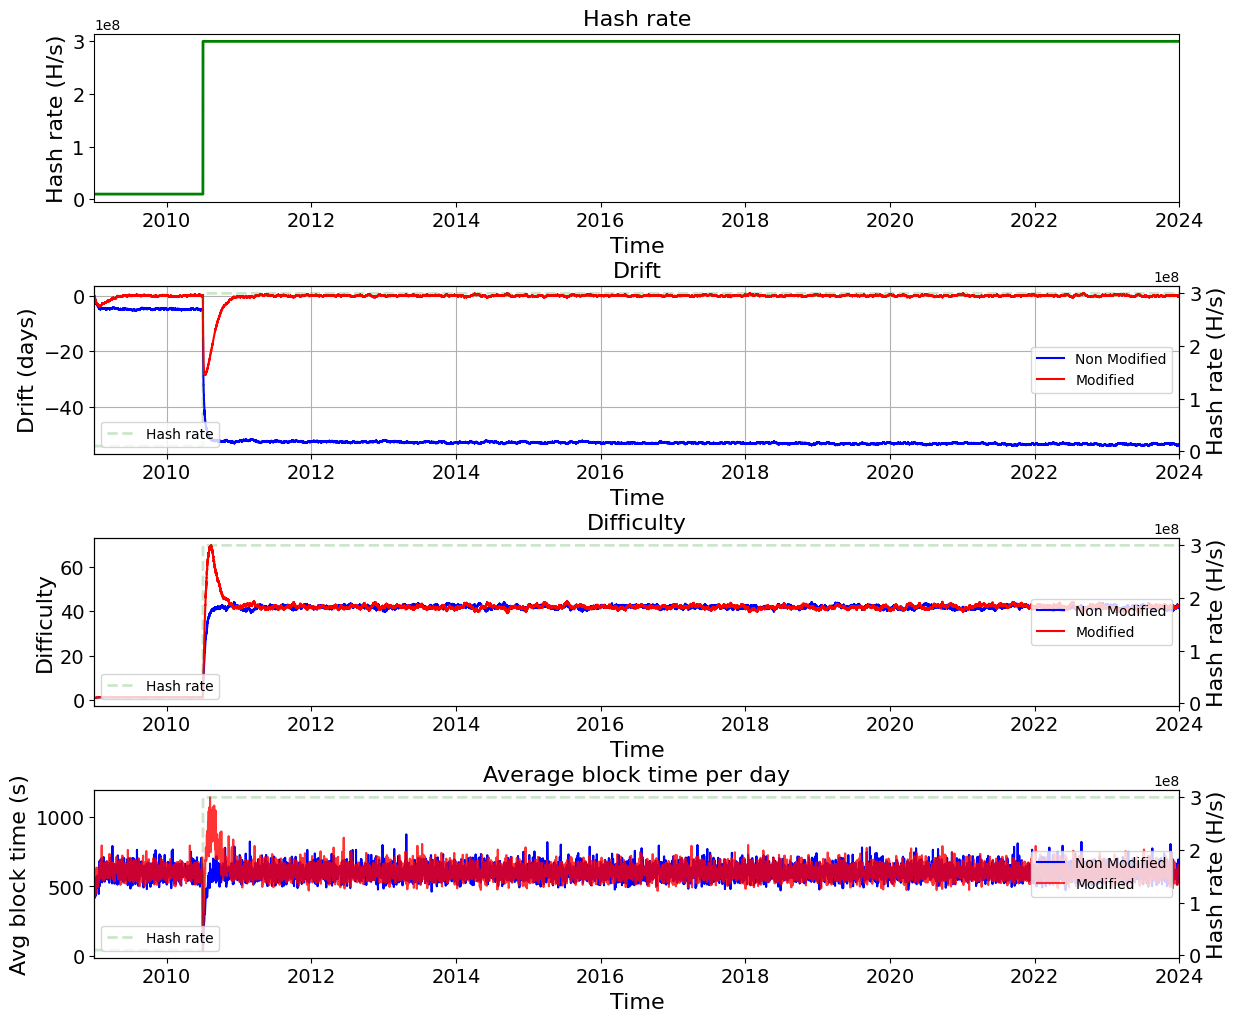

In [117]:
# start_date = pd.Timestamp('2009-1-1')
# end_date = pd.Timestamp('2014-3-7')
start_date = min(df_non_modified['median_time'])
end_date = max(df_non_modified['median_time'])

df_modified['median_time'] = pd.to_datetime(df_modified['median_time'])

# fig, axs = plt.subplots(5, 1, figsize=(14, 14))
fig, axs = plt.subplots(4, 1, figsize=(14, 12))

axs[0].plot(df_non_modified['median_time'], df_non_modified['real_hash_rate'], color='green', linewidth=2)
axs[0].set_title('Hash rate', fontsize=16)
axs[0].set_xlabel('Time', fontsize=16)
axs[0].set_ylabel('Hash rate (H/s)', fontsize=16)
axs[0].set_xlim(start_date, end_date)
axs[0].tick_params(axis='both', which='major', labelsize=14)
# axs[0].set_yscale('log')

ax2_1 = axs[1].twinx()
ax2_2 = axs[2].twinx()
ax2_3 = axs[3].twinx()
# ax2_4 = axs[4].twinx()

# Plot data on axs[1] and ax2_1
axs[1].plot(df_non_modified['median_time'], df_non_modified['skew'] * 14, color='blue', label='Non Modified')
axs[1].plot(df_modified['median_time'], df_modified['skew'] * 14, color='red', label='Modified')
axs[1].set_title('Drift', fontsize=16)
axs[1].set_xlabel('Time', fontsize=16)
axs[1].set_ylabel('Drift (days)', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].legend(loc='center right')
axs[1].grid()
# axs[1].set_ylim(-50, 0)
axs[1].set_xlim(start_date, end_date)
ax2_1.plot(df_non_modified['median_time'], df_non_modified['real_hash_rate'], color='green', label='Hash rate', linestyle='--', alpha=0.2, linewidth=2)
ax2_1.set_ylabel('Hash rate (H/s)', fontsize=16)
ax2_1.tick_params(axis='both', which='major', labelsize=14)
ax2_1.legend(loc='lower left')

# Plot data on axs[2] and ax2_2
axs[2].plot(df_non_modified['median_time'], df_non_modified['difficulty'], color='blue', label='Non Modified')
axs[2].plot(df_modified['median_time'], df_modified['difficulty'], color='red', label='Modified')
axs[2].set_title('Difficulty', fontsize=16)
axs[2].set_xlabel('Time', fontsize=16)
axs[2].set_ylabel('Difficulty', fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)
axs[2].legend(loc='center right')
axs[2].set_xlim(start_date, end_date)
# axs[2].set_yscale('log')
ax2_2.plot(df_non_modified['median_time'], df_non_modified['real_hash_rate'], color='green', label='Hash rate', linestyle='--', alpha=0.2, linewidth=2)
ax2_2.set_ylabel('Hash rate (H/s)', fontsize=16)
ax2_2.tick_params(axis='both', which='major', labelsize=14)
ax2_2.legend(loc='lower left')

# Plot data on axs[3] and ax2_3
axs[3].plot(q_res_non_modified_avg_block_time['day'], q_res_non_modified_avg_block_time['avg_block_time'], color='blue', label='Non Modified')
axs[3].plot(q_res_modified_avg_block_time['day'], q_res_modified_avg_block_time['avg_block_time'], color='red', label='Modified', alpha=0.8)
axs[3].set_title('Average block time per day', fontsize=16)
axs[3].set_xlabel('Time', fontsize=16)
axs[3].set_ylabel('Avg block time (s)', fontsize=16)
axs[3].tick_params(axis='both', which='major', labelsize=14)
axs[3].legend(loc='center right')
axs[3].set_xlim(start_date, end_date)
ax2_3.plot(df_non_modified['median_time'], df_non_modified['real_hash_rate'], color='green', label='Hash rate', linestyle='--', alpha=0.2, linewidth=2)
ax2_3.set_ylabel('Hash rate (H/s)', fontsize=16)
ax2_3.tick_params(axis='both', which='major', labelsize=14)
ax2_3.legend(loc='lower left')

# # Plot data on axs[4] and ax2_4
# axs[4].plot(q_res_non_modified_hour_count['hour'], q_res_non_modified_hour_count['record_count'], color='blue', label='Non Modified')
# axs[4].plot(q_res_modified_hour_count['hour'], q_res_modified_hour_count['record_count'], color='red', label='Modified', alpha=0.8)
# axs[4].set_title('Number of blocks per hour')
# axs[4].set_xlabel('Time')
# axs[4].set_ylabel('Number of blocks')
# axs[4].legend()
# axs[4].set_xlim(start_date, end_date)
# ax2_4.plot(df_non_modified['median_time'], df_non_modified['real_hash_rate'], color='green', label='Hash rate', linestyle='--', alpha=0.5, linewidth=2)
# ax2_4.set_ylabel('Hash rate (H/s)')
# ax2_4.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()

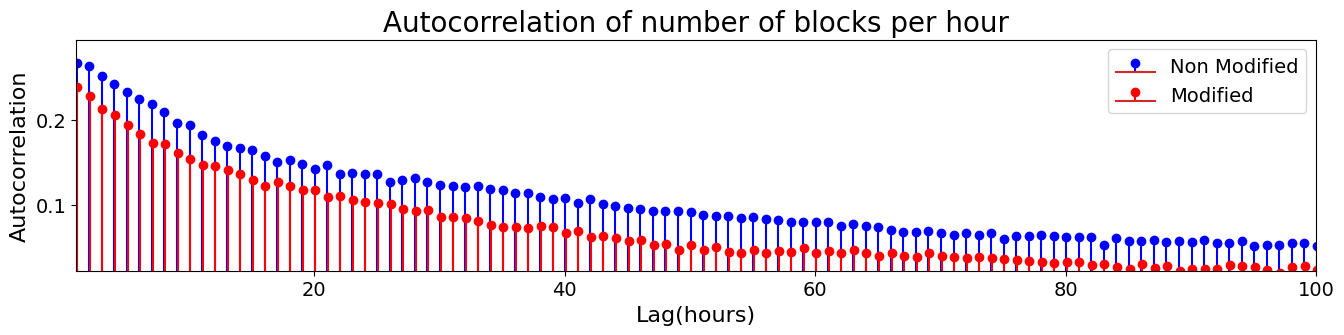

In [118]:
x_lim = 100
non_modified_count_acf_values = acf(q_res_non_modified_hour_count['record_count'], nlags=x_lim)
modified_count_acf_values = acf(q_res_modified_hour_count['record_count'], nlags=x_lim)

lags = np.arange(0, x_lim + 1)
width = 0.2
plt.stem(lags + 0.25 * width, non_modified_count_acf_values, label='Non Modified', linefmt='blue')
plt.stem(lags + 0.5 * width, modified_count_acf_values, label='Modified', linefmt='red')
plt.title('Autocorrelation of number of blocks per hour', fontsize=20)
plt.xlabel('Lag(hours)', fontsize=16)
plt.ylabel('Autocorrelation', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gcf().set_size_inches(16, 3)
plt.legend(fontsize=14)
plt.ylim(-0.5, 0.5)
plt.ylim(min(min(non_modified_count_acf_values[1:]), min(modified_count_acf_values[1:])) * 1.1, max(max(non_modified_count_acf_values[1:]), max(modified_count_acf_values[1:])) * 1.1)
plt.xlim(1, x_lim)
plt.show()

In [119]:
# fig, axs = plt.subplots(2, 1, figsize=(16, 12))
# plot_acf(q_res_non_modified_hour_count['record_count'],ax=axs[0], lags=100, color='red')
# axs[0].set_xlim(1,100)
# axs[0].set_ylim(-0.1,0.1)

# plot_acf(q_res_modified_hour_count['record_count'],ax=axs[1], lags=100, color='red')
# axs[1].set_xlim(1,100)
# axs[1].set_ylim(-0.1,0.1)

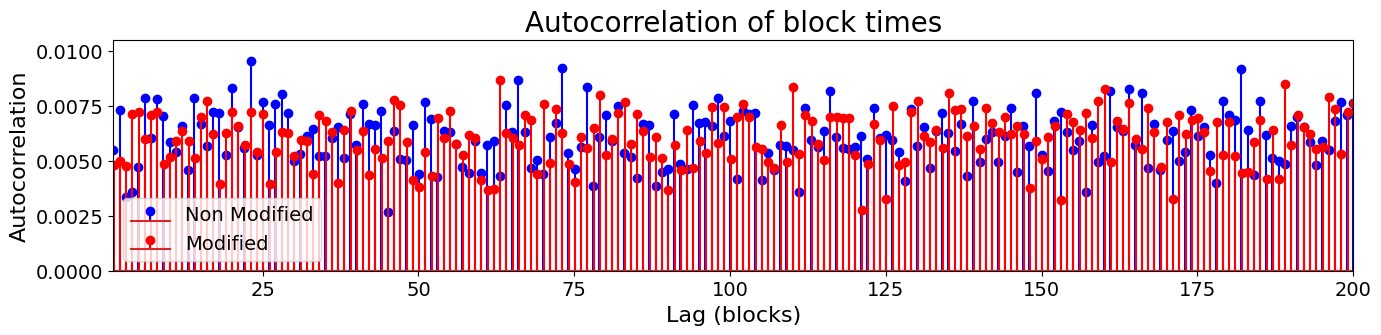

In [120]:
x_lim = 200

non_modified_block_times_acf_values = acf(df_non_modified['block_time'], nlags=x_lim)
modified_block_times_acf_values = acf(df_modified['block_time'], nlags=x_lim)

lags = np.arange(0, x_lim + 1)
width = 0.2
plt.stem(lags + 0.25 * width, non_modified_block_times_acf_values, label='Non Modified', linefmt='blue')
plt.stem(lags + 0.5 * width, modified_block_times_acf_values, label='Modified', linefmt='red')
plt.title('Autocorrelation of block times', fontsize=20)
plt.xlabel('Lag (blocks)', fontsize=16)
plt.ylabel('Autocorrelation', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gcf().set_size_inches(16, 3)
plt.legend(fontsize=14)
plt.ylim(min(min(non_modified_block_times_acf_values[1:]),min(modified_block_times_acf_values[1:]),0) * 1.1, max(max(non_modified_block_times_acf_values[1:]),max(modified_block_times_acf_values[1:]),0) * 1.1)
plt.xlim(1, x_lim)
plt.show()

In [121]:
# fig, axs = plt.subplots(2, 1, figsize=(16, 12))
# plot_acf(df_non_modified['block_time'],ax=axs[0], lags=100, color='red')
# axs[0].set_xlim(1,100)
# axs[0].set_ylim(-0.1,0.1)

# plot_acf(df_modified['block_time'],ax=axs[1], lags=100, color='red')
# axs[1].set_xlim(1,100)
# axs[1].set_ylim(-0.1,0.1)